# LightGBM Modeling Workflow Overview

This notebook documents a comprehensive workflow for developing, optimizing, and interpreting a LightGBM classification model to predict drinking status (`DRK_YN`) based on health and demographic features.

---

## Workflow Steps

### 1. Load Preprocessed Data  
We begin by loading the cleaned and feature-engineered datasets (`X_train_lgb`, `X_val_lgb`, `X_test_lgb`, and their corresponding labels) from the preprocessed data directory.

### 2. Baseline Model Training  
An initial LightGBM model is trained using default hyperparameters to establish baseline performance. Evaluation metrics include AUC, accuracy, precision, recall, F1-score, as well as confusion matrix and ROC curve visualizations.

### 3. Feature Importance Analysis  
The baseline model’s built-in feature importance scores are used to identify the most influential predictors. These insights help guide further dimensionality reduction and model interpretation.

### 4. Model Training with Selected Features  
The model is retrained using only the top N most important features. Validation performance is compared to the baseline to assess whether a simpler model can achieve similar results.

### 5. Hyperparameter Tuning with Optuna  
Optuna is employed to search for the optimal combination of hyperparameters by maximizing AUC on the validation set. The search space covers parameters such as `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `reg_alpha`, and `reg_lambda`.

### 6. Final Model Training with Optimized Parameters  
The model is retrained using the best hyperparameters identified by Optuna, and its performance is evaluated on both the validation and test sets.

### 7. Model Evaluation and Visualization  
A summary table is created to compare the performance of the baseline and tuned models across validation and test sets. Bar plots and other visualizations are included to facilitate direct comparison.

### 8. Model Interpretation with SHAP  
SHAP (SHapley Additive Explanations) is used to interpret the model’s predictions at the feature level. Both summary and bar plots are generated to provide transparency into the model’s decision-making process.

### 9. Error Analysis and Visualization  
Comprehensive error analysis is conducted using the model’s predictions. This includes identifying and visualizing different error types (TP, TN, FP, FN), analyzing feature distributions for error samples, projecting error types using PCA, and generating local SHAP explanations for selected samples.

### 10. Save Final Model  
The final trained model is saved as a `.pkl` file using joblib, making it available for deployment or future use.

# 1. Load Processed Data

In [1]:
from pathlib import Path
import pandas as pd

data_dir = Path("../data/processed")

X_train_lgb = pd.read_csv(data_dir / "X_train_lgb.csv")
X_val_lgb = pd.read_csv(data_dir / "X_val_lgb.csv")
X_test_lgb = pd.read_csv(data_dir / "X_test_lgb.csv")

y_train_lgb = pd.read_csv(data_dir / "y_train_lgb.csv").squeeze() 
y_val_lgb = pd.read_csv(data_dir / "y_val_lgb.csv").squeeze()
y_test_lgb = pd.read_csv(data_dir / "y_test_lgb.csv").squeeze()

print("Training set:", X_train_lgb.shape, y_train_lgb.shape)
print("Validation set:", X_val_lgb.shape, y_val_lgb.shape)
print("Test set:", X_test_lgb.shape, y_test_lgb.shape)

Training set: (693942, 35) (693942,)
Validation set: (148702, 35) (148702,)
Test set: (148702, 35) (148702,)


In [2]:
X_train_lgb.head()

,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,...,vision_avg,hearing_avg,AST_ALT_ratio,risk_waist,risk_bp,risk_tg,risk_chole,risk_glu,metabolic_risk_count,sex_Male
0,45.0,170.0,70.0,85.5,1.0,1.2,1.0,1.0,108.0,68.0,...,1.10,1.0,2.125000,1.0,0.0,0.0,1.0,0.0,2.0,False
1,55.0,160.0,65.0,79.0,0.8,0.7,1.0,1.0,114.0,68.0,...,0.75,1.0,1.384615,0.0,0.0,0.0,1.0,1.0,2.0,False
2,55.0,155.0,80.0,101.9,0.9,1.0,1.0,1.0,116.0,67.0,...,0.95,1.0,0.736842,1.0,0.0,1.0,0.0,1.0,3.0,False
3,65.0,150.0,55.0,75.0,0.9,0.8,1.0,1.0,136.0,84.0,...,0.85,1.0,1.400000,0.0,1.0,1.0,1.0,0.0,3.0,False
4,40.0,155.0,60.0,85.0,0.9,1.2,1.0,1.0,117.0,69.0,...,1.05,1.0,1.545455,1.0,0.0,0.0,1.0,1.0,3.0,False


# 2. Baseline LightGBM Model

- This section trains a baseline LightGBM classifier on the training data and evaluates its performance on the validation set. Key metrics—including AUC, accuracy, precision, recall, and F1-score—are reported, along with a detailed classification report. The results are visualized using a confusion matrix and ROC curve to provide a comprehensive assessment of model performance.

In [ ]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    objective='binary',
    random_state=42,
    verbose=-1
)

# Fit model
lgb_model.fit(X_train_lgb, y_train_lgb)

y_val_pred = lgb_model.predict(X_val_lgb)
y_val_proba = lgb_model.predict_proba(X_val_lgb)[:, 1]

Validation Set Performance (Baseline LightGBM):
AUC:        0.8222
Accuracy:   0.7396
Precision:  0.7358
Recall:     0.7473
F1 Score:   0.7415

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74     74379
           1       0.74      0.75      0.74     74323

    accuracy                           0.74    148702
   macro avg       0.74      0.74      0.74    148702
weighted avg       0.74      0.74      0.74    148702



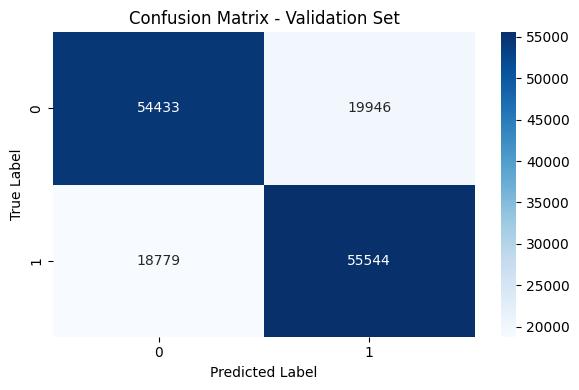

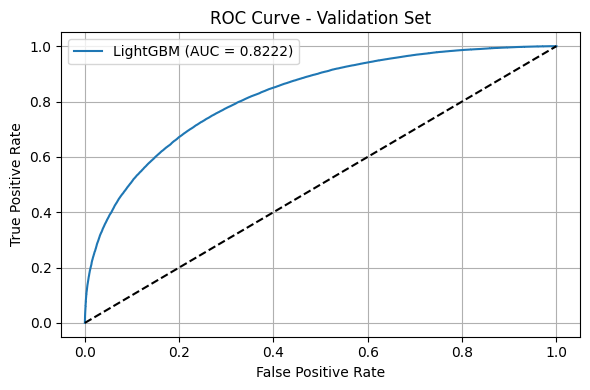

In [4]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation metrics
val_auc = roc_auc_score(y_val_lgb, y_val_proba)
val_acc = accuracy_score(y_val_lgb, y_val_pred)
val_precision = precision_score(y_val_lgb, y_val_pred)
val_recall = recall_score(y_val_lgb, y_val_pred)
val_f1 = f1_score(y_val_lgb, y_val_pred)
conf_mat = confusion_matrix(y_val_lgb, y_val_pred)

# Print results
print("Validation Set Performance (Baseline LightGBM):")
print(f"AUC:        {val_auc:.4f}")
print(f"Accuracy:   {val_acc:.4f}")
print(f"Precision:  {val_precision:.4f}")
print(f"Recall:     {val_recall:.4f}")
print(f"F1 Score:   {val_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val_lgb, y_val_pred))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val_lgb, y_val_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"LightGBM (AUC = {val_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- The baseline LightGBM model achieves an AUC of 0.8222 and an accuracy of 73.96% on the validation set. Precision, recall, and F1-score are all balanced at 0.74 for both classes, indicating consistent and reliable classification. The confusion matrix shows a similar number of true positives (55,544) and true negatives (54,433), with false positives (19,946) and false negatives (18,779) at comparable levels. The ROC curve demonstrates strong discriminative ability, confirming the model’s robust performance on this task.

In [5]:
y_val_pred_base = y_val_pred
y_val_proba_base = y_val_proba

# 3. Feature Importance Analysis

- This section extracts and ranks feature importances from the baseline LightGBM model. The top 10 most influential features are visualized using a horizontal bar plot, providing insight into which variables contribute most to the model’s predictions.

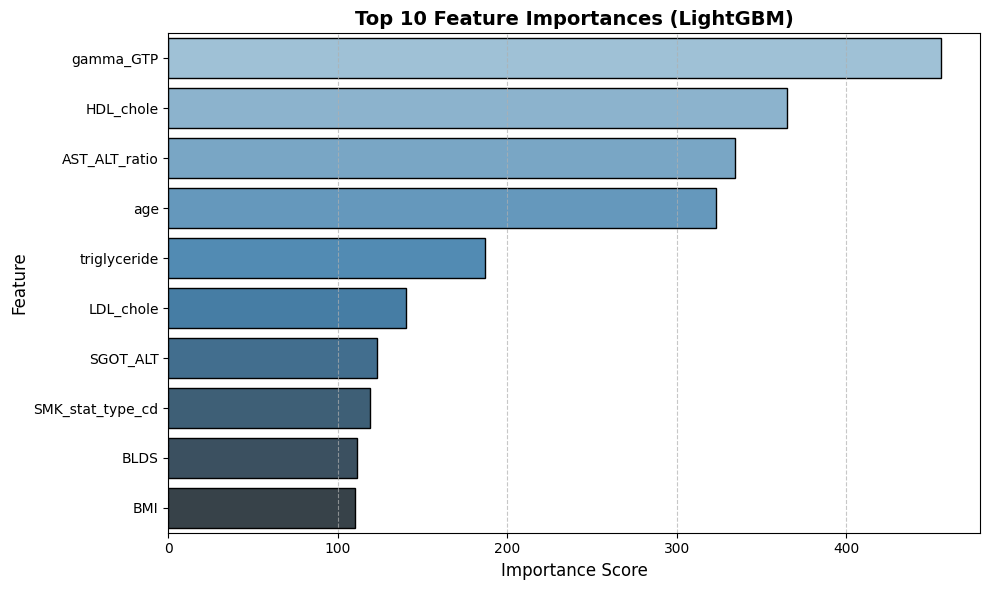

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importances
importances = lgb_model.feature_importances_
feature_names = X_train_lgb.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top 10 features to display
top_n = 10
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature',
    hue='Feature',
    data=top_features,
    palette='Blues_d',
    edgecolor='black'
)

plt.title('Top 10 Feature Importances (LightGBM)', fontsize=14, weight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- The top features driving the LightGBM model’s predictions are gamma_GTP, HDL_chole, AST_ALT_ratio, and age, followed by triglyceride, LDL_chole, and SGOT_ALT. These results highlight the importance of liver function indicators, cholesterol levels, and age in predicting the target outcome. Lifestyle (SMK_stat_type_cd) and metabolic features (BMI, BLDS) also contribute, but to a lesser extent.

# 4. Model Performance with Selected Features

## Optimal Feature Subset Selection
- This section evaluates model performance as a function of the number of top-ranked features. By incrementally adding features based on their importance and recording the validation AUC for each subset, it identifies the optimal number of features that yields the highest predictive performance. The results are visualized in a line plot, and the best-performing feature count is reported for further model development.

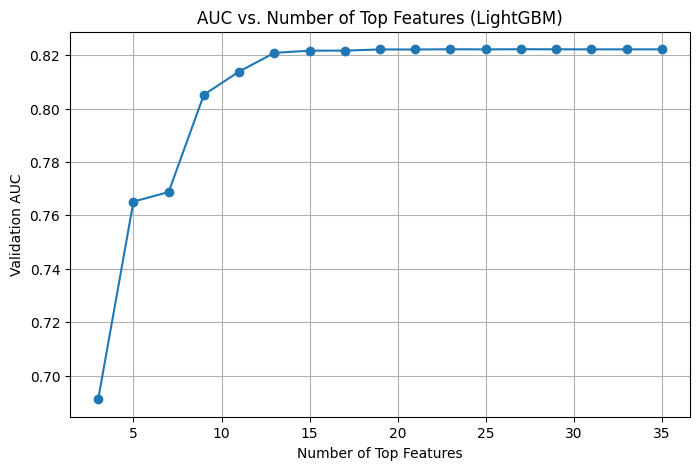

Best number of features: 27, Best AUC: 0.8222


In [7]:
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np

auc_scores = []
feature_range = range(3, len(importance_df)+1, 2)  # Test every 2 features

for n in feature_range:
    top_features = importance_df.head(n)['Feature'].tolist()
    X_train_sel = X_train_lgb[top_features]
    X_val_sel = X_val_lgb[top_features]
    
    model = LGBMClassifier(
        objective='binary',
        random_state=42
    )
    model.fit(X_train_sel, y_train_lgb)
    y_val_proba = model.predict_proba(X_val_sel)[:, 1]
    auc = roc_auc_score(y_val_lgb, y_val_proba)
    auc_scores.append(auc)

# Visualize the AUC vs. Number of Top Features
plt.figure(figsize=(8, 5))
plt.plot(feature_range, auc_scores, marker='o')
plt.xlabel('Number of Top Features')
plt.ylabel('Validation AUC')
plt.title('AUC vs. Number of Top Features (LightGBM)')
plt.grid(True)
plt.show()

# Find the number of features with the highest AUC
best_n = feature_range[np.argmax(auc_scores)]
print(f"Best number of features: {best_n}, Best AUC: {max(auc_scores):.4f}")

- The LightGBM model is retrained using the optimal feature subset and evaluated on the validation and test sets. Performance metrics and visualizations, including the confusion matrix and ROC curve, provide a clear assessment of the model’s effectiveness.

Validation Set:
AUC: 0.8222
Accuracy: 0.7397
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74     74379
           1       0.74      0.75      0.74     74323

    accuracy                           0.74    148702
   macro avg       0.74      0.74      0.74    148702
weighted avg       0.74      0.74      0.74    148702



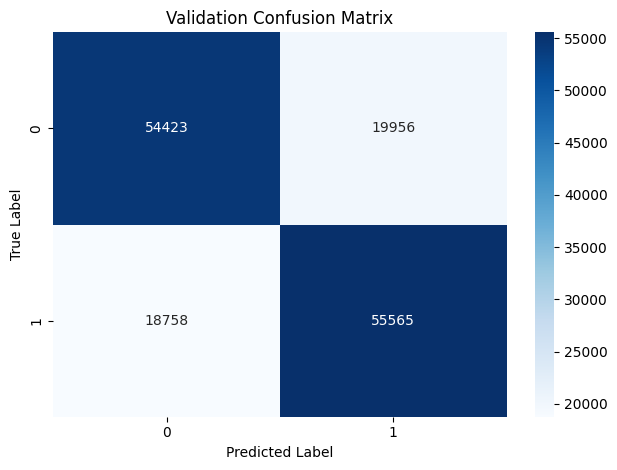

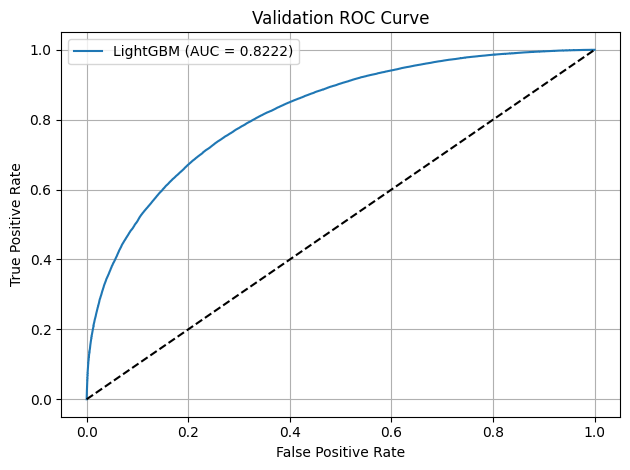

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report, 
    confusion_matrix, roc_curve
)
from lightgbm import LGBMClassifier

# Select top best_n features
selected_features = importance_df.head(best_n)['Feature'].tolist()
X_train_sel = X_train_lgb[selected_features]
X_val_sel = X_val_lgb[selected_features]
X_test_sel = X_test_lgb[selected_features]

# Train model
selected_model = LGBMClassifier(
    objective='binary',
    random_state=42
)
selected_model.fit(X_train_sel, y_train_lgb)

# Predictions
y_val_proba = selected_model.predict_proba(X_val_sel)[:, 1]
y_val_pred = selected_model.predict(X_val_sel)
y_test_proba = selected_model.predict_proba(X_test_sel)[:, 1]
y_test_pred = selected_model.predict(X_test_sel)

# Evaluation scores
print("Validation Set:")
print(f"AUC: {roc_auc_score(y_val_lgb, y_val_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_val_lgb, y_val_pred):.4f}")
print("Classification Report:\n", classification_report(y_val_lgb, y_val_pred))

# Confusion Matrix - Validation
cm_val = confusion_matrix(y_val_lgb, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ROC Curve - Validation
fpr, tpr, _ = roc_curve(y_val_lgb, y_val_proba)
plt.plot(fpr, tpr, label='LightGBM (AUC = %.4f)' % roc_auc_score(y_val_lgb, y_val_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Validation ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- The feature-selected LightGBM model achieves an AUC of 0.8222 and an accuracy of 73.97% on the validation set. Precision, recall, and F1-score are all balanced at 0.74 for both classes, indicating stable and consistent classification performance. The confusion matrix shows a similar number of true positives (55,565) and true negatives (54,423), with false positives (19,956) and false negatives (18,758) at comparable levels. The ROC curve further confirms strong discriminative ability.

In [9]:
y_val_pred_fs = y_val_pred
y_val_proba_fs = y_val_proba

# 5. Hyperparameter Tuning with Optuna

- This section applies Optuna to perform multi-objective hyperparameter optimization for the LightGBM model using 5-fold cross-validation. The optimization simultaneously maximizes mean and minimizes standard deviation for AUC, F1 score, and accuracy. All trial results are saved, and the best parameter set is selected based on mean AUC.

In [12]:
import optuna
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from lightgbm import LGBMClassifier

# Ensure results directory exists
os.makedirs('results', exist_ok=True)

results_list = []

def objective(trial):
    # Define hyperparameter search space
    params = {
        'objective': 'binary',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs, f1s, accs = [], [], []
    for train_idx, val_idx in skf.split(X_train_lgb, y_train_lgb):
        X_tr, X_val = X_train_lgb.iloc[train_idx], X_train_lgb.iloc[val_idx]
        y_tr, y_val = y_train_lgb.iloc[train_idx], y_train_lgb.iloc[val_idx]
        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)
        aucs.append(roc_auc_score(y_val, y_pred_proba))
        f1s.append(f1_score(y_val, y_pred))
        accs.append(accuracy_score(y_val, y_pred))
    
    # Record results
    result = {
        'mean_auc': np.mean(aucs),
        'std_auc': np.std(aucs),
        'mean_f1': np.mean(f1s),
        'std_f1': np.std(f1s),
        'mean_acc': np.mean(accs),
        'std_acc': np.std(accs),
        **params
    }
    results_list.append(result)
    
    # Optimize for mean AUC (can be changed for other objectives)
    return np.mean(aucs)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Save all trial results
results_df = pd.DataFrame(results_list)
results_df.to_csv('../results/lightgbm_cv_optuna_results.csv', index=False)

# Print best result
print('Best trial:')
print(f"AUC: {study.best_value:.4f}")
print('Best parameters:', study.best_params)

[I 2025-05-13 23:52:12,991] A new study created in memory with name: no-name-afbc262f-3e43-4aff-af5a-7664e590776a
[I 2025-05-13 23:52:29,309] Trial 0 finished with value: 0.8222818395881966 and parameters: {'n_estimators': 163, 'max_depth': 7, 'learning_rate': 0.13512982331590692, 'subsample': 0.9150614685840415, 'colsample_bytree': 0.9266229780313062, 'reg_alpha': 0.09765259294989581, 'reg_lambda': 0.9624776772499172}. Best is trial 0 with value: 0.8222818395881966.
[I 2025-05-13 23:52:40,847] Trial 1 finished with value: 0.8210908400439975 and parameters: {'n_estimators': 176, 'max_depth': 3, 'learning_rate': 0.16340374210549444, 'subsample': 0.8539666520598498, 'colsample_bytree': 0.9224553295391982, 'reg_alpha': 0.02049300220144956, 'reg_lambda': 0.8327726423366012}. Best is trial 0 with value: 0.8222818395881966.
[I 2025-05-13 23:53:05,759] Trial 2 finished with value: 0.8215327872271253 and parameters: {'n_estimators': 347, 'max_depth': 12, 'learning_rate': 0.1776244814672266, 's

Best trial:
AUC: 0.8228
Best parameters: {'n_estimators': 368, 'max_depth': 6, 'learning_rate': 0.062183804692550616, 'subsample': 0.951461897994358, 'colsample_bytree': 0.5680733562490614, 'reg_alpha': 0.5544878201225123, 'reg_lambda': 0.7982471588546619}


In [23]:
results_df

,mean_auc,std_auc,mean_f1,std_f1,mean_acc,std_acc,objective,random_state,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda
0,0.822282,0.000810,0.740093,0.001333,0.739176,0.001181,binary,42,163,7,0.135130,0.915061,0.926623,0.097653,0.962478
1,0.821091,0.000782,0.740555,0.000891,0.738191,0.000584,binary,42,176,3,0.163404,0.853967,0.922455,0.020493,0.832773
2,0.821533,0.000726,0.738862,0.001225,0.738531,0.000954,binary,42,347,12,0.177624,0.833127,0.992016,0.220909,0.971144
3,0.822725,0.000817,0.740045,0.001196,0.739438,0.001136,binary,42,375,10,0.075816,0.848226,0.744755,0.899010,0.893081
4,0.821955,0.000743,0.739521,0.001030,0.738935,0.000917,binary,42,236,12,0.186427,0.679097,0.703805,0.158829,0.921007
5,0.822367,0.000786,0.740203,0.001099,0.739157,0.000947,binary,42,154,7,0.105357,0.666325,0.957750,0.233668,0.208496
6,0.822508,0.000816,0.740379,0.001112,0.739386,0.001016,binary,42,240,11,0.052495,0.750139,0.678471,0.795765,0.862895
7,0.821570,0.000793,0.738694,0.000839,0.738363,0.000781,binary,42,419,7,0.173762,0.784124,0.888457,0.911715,0.864156
8,0.818371,0.000866,0.739695,0.000988,0.736147,0.000832,binary,42,337,3,0.031104,0.621736,0.508627,0.049495,0.048736
9,0.821092,0.000758,0.738678,0.001265,0.738214,0.001119,binary,42,201,10,0.258887,0.688332,0.581344,0.393304,0.408314


# 6. Final Model Training with Best Parameters

- This section selects the best hyperparameter set from the Pareto optimal trials, retrains the LightGBM model on the full training set, and evaluates its performance on both validation and test sets. Key metrics and visualizations—including the confusion matrix and ROC curve—are provided to assess the tuned model’s effectiveness.

Validation Set Performance (Tuned):
AUC: 0.8231
Accuracy: 0.7405
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74     74379
           1       0.74      0.75      0.74     74323

    accuracy                           0.74    148702
   macro avg       0.74      0.74      0.74    148702
weighted avg       0.74      0.74      0.74    148702



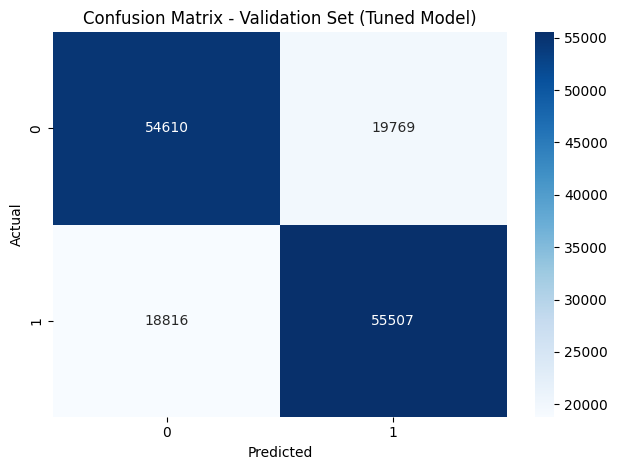

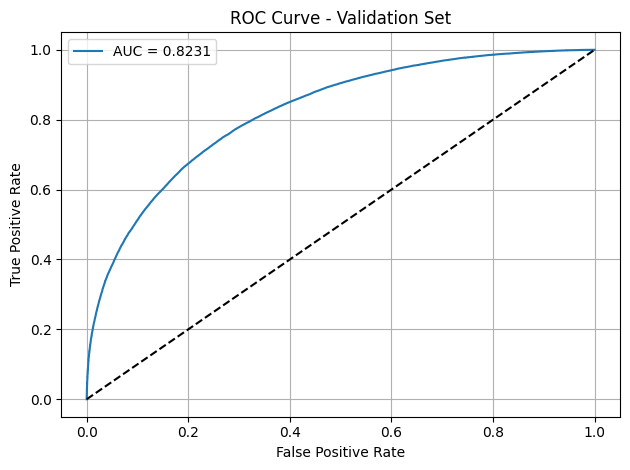

In [15]:
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Get all Pareto optimal solutions
pareto_trials = study.best_trials

# Select the trial with the highest mean AUC (assumed to be the first objective)
best_trial = max(pareto_trials, key=lambda t: t.values[0])

best_params = best_trial.params
best_params.update({
    'objective': 'binary',
    'random_state': 42
})

# Retrain on training set
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_lgb, y_train_lgb)

# Predict on validation and test sets
y_val_proba = final_model.predict_proba(X_val_lgb)[:, 1]
y_val_pred = final_model.predict(X_val_lgb)

y_test_proba = final_model.predict_proba(X_test_lgb)[:, 1]
y_test_pred = final_model.predict(X_test_lgb)

# Evaluation (Validation Set)
print("Validation Set Performance (Tuned):")
print(f"AUC: {roc_auc_score(y_val_lgb, y_val_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_val_lgb, y_val_pred):.4f}")
print("Classification Report:\n", classification_report(y_val_lgb, y_val_pred))

# Confusion Matrix - Validation
cm_val = confusion_matrix(y_val_lgb, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title("Confusion Matrix - Validation Set (Tuned Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve - Validation
fpr, tpr, _ = roc_curve(y_val_lgb, y_val_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_val_lgb, y_val_proba):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Validation Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- The tuned LightGBM model achieves an AUC of 0.8231 and an accuracy of 74.05% on the validation set. Precision, recall, and F1-score are all balanced at 0.74 for both classes, indicating consistent performance across positive and negative cases. The confusion matrix shows a similar number of true positives (55,507) and true negatives (54,610), with false positives (19,769) and false negatives (18,816) at comparable levels. The ROC curve demonstrates strong discriminative ability, with the curve well above the diagonal and an AUC value supporting robust model performance.

In [16]:
y_val_pred_tuned = y_val_pred
y_val_proba_tuned = y_val_proba
y_test_pred_tuned = y_test_pred
y_test_proba_tuned = y_test_proba

# 7. Model Evaluation and Visualization

- These sections compute and summarize key evaluation metrics (AUC, accuracy, precision, recall, and F1 score) for the baseline, feature-selected, and tuned LightGBMt models on both validation and test sets. The results are presented in a comparison table and visualized using a grouped bar plot, providing a clear and direct comparison of model performance across different configurations.

In [17]:
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
)

# Create a comparison DataFrame for key metrics
comparison_df = pd.DataFrame({
    'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Baseline (Val)': [
        roc_auc_score(y_val_lgb, y_val_proba_base),
        accuracy_score(y_val_lgb, y_val_pred_base),
        precision_score(y_val_lgb, y_val_pred_base),
        recall_score(y_val_lgb, y_val_pred_base),
        f1_score(y_val_lgb, y_val_pred_base)
    ],
    'Feature-Selected (Val)': [
        roc_auc_score(y_val_lgb, y_val_proba_fs),
        accuracy_score(y_val_lgb, y_val_pred_fs),
        precision_score(y_val_lgb, y_val_pred_fs),
        recall_score(y_val_lgb, y_val_pred_fs),
        f1_score(y_val_lgb, y_val_pred_fs)
    ],
    'Tuned (Val)': [
        roc_auc_score(y_val_lgb, y_val_proba_tuned),
        accuracy_score(y_val_lgb, y_val_pred_tuned),
        precision_score(y_val_lgb, y_val_pred_tuned),
        recall_score(y_val_lgb, y_val_pred_tuned),
        f1_score(y_val_lgb, y_val_pred_tuned)
    ],
    'Tuned (Test)': [
        roc_auc_score(y_test_lgb, y_test_proba),
        accuracy_score(y_test_lgb, y_test_pred),
        precision_score(y_test_lgb, y_test_pred),
        recall_score(y_test_lgb, y_test_pred),
        f1_score(y_test_lgb, y_test_pred)
    ]
})

# Round results for better readability
comparison_df.iloc[:, 1:] = comparison_df.iloc[:, 1:].round(4)

print(comparison_df)

      Metric  Baseline (Val)  Feature-Selected (Val)  Tuned (Val)  \
0        AUC          0.8222                  0.8222       0.8231   
1   Accuracy          0.7396                  0.7397       0.7405   
2  Precision          0.7358                  0.7358       0.7374   
3     Recall          0.7473                  0.7476       0.7468   
4   F1 Score          0.7415                  0.7416       0.7421   

   Tuned (Test)  
0        0.8249  
1        0.7418  
2        0.7402  
3        0.7449  
4        0.7425  


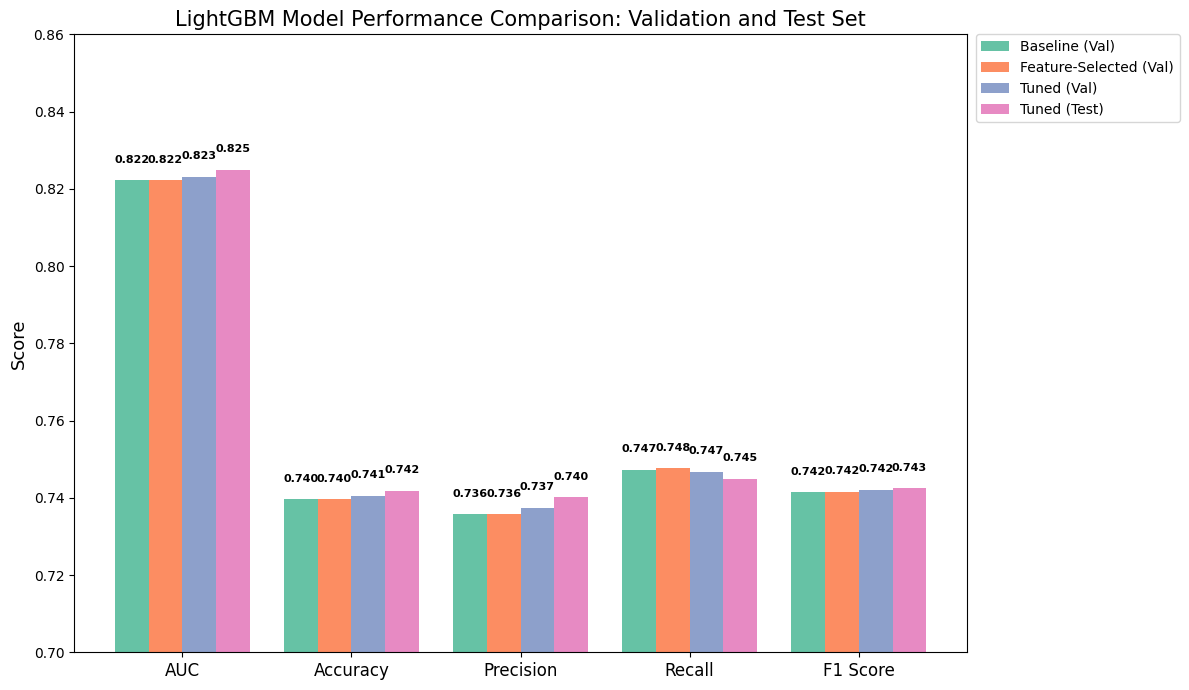

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a distinct color palette
palette = sns.color_palette("Set2", 4)

plt.figure(figsize=(12, 7))
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
x = range(len(metrics))
bar_width = 0.2

bars1 = plt.bar(x, comparison_df['Baseline (Val)'], width=bar_width, label='Baseline (Val)', align='center', color=palette[0])
bars2 = plt.bar([i + bar_width for i in x], comparison_df['Feature-Selected (Val)'], width=bar_width, label='Feature-Selected (Val)', align='center', color=palette[1])
bars3 = plt.bar([i + 2*bar_width for i in x], comparison_df['Tuned (Val)'], width=bar_width, label='Tuned (Val)', align='center', color=palette[2])
bars4 = plt.bar([i + 3*bar_width for i in x], comparison_df['Tuned (Test)'], width=bar_width, label='Tuned (Test)', align='center', color=palette[3])

plt.xticks([i + 1.5*bar_width for i in x], metrics, fontsize=12)
plt.ylabel('Score', fontsize=13)
plt.title('LightGBM Model Performance Comparison: Validation and Test Set', fontsize=15)
plt.ylim(0.7, 0.86)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0., fontsize=10)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, height + 0.004,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold'
        )

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

plt.tight_layout()
plt.show()

- All three LightGBM models—baseline, feature-selected, and tuned—demonstrate very similar performance on the validation set, with AUC values around 0.822 and accuracy, precision, recall, and F1 scores all balanced at approximately 0.74. Feature selection does not lead to any loss in predictive power, indicating that a simpler model can be achieved without sacrificing accuracy. Hyperparameter tuning provides a slight improvement, with the tuned model achieving the highest AUC (0.8231) and accuracy (0.7405) on the validation set, and strong generalization to the test set (AUC 0.8249, accuracy 0.7418). 

# 8. SHAP Model Interpretation

In [20]:
!pip install shap

/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


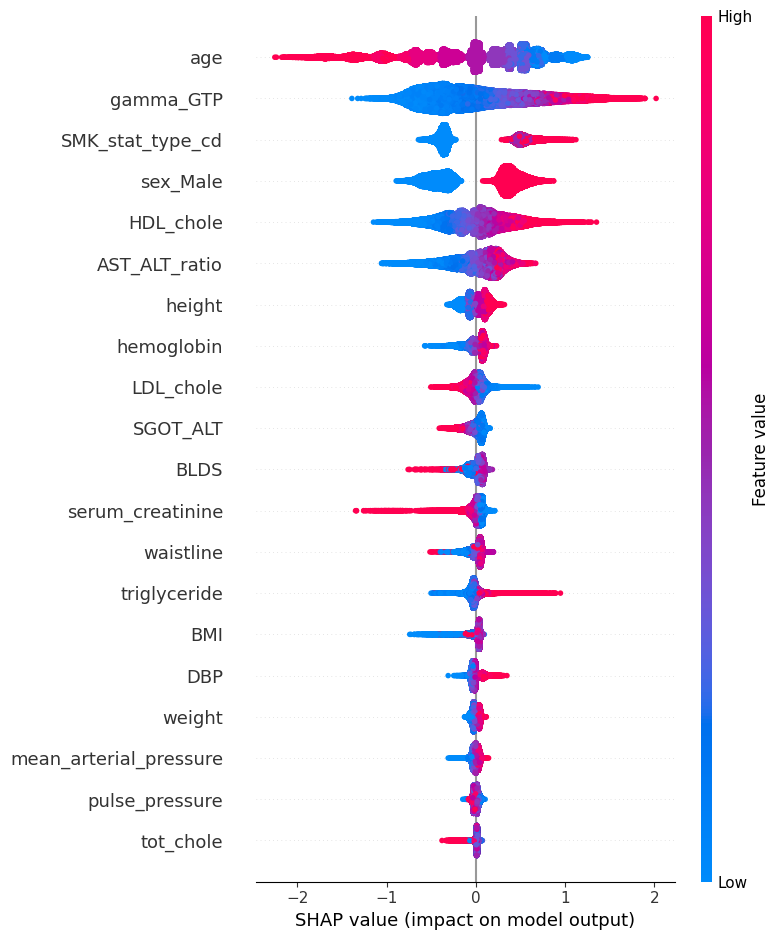

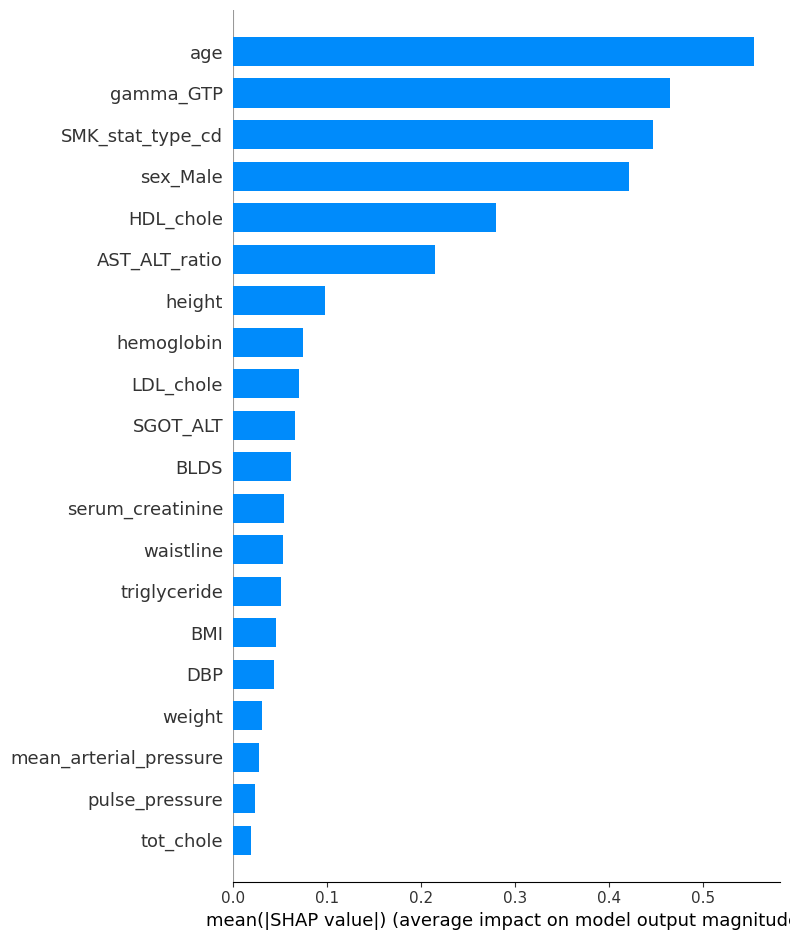

In [ ]:
import shap

explainer = shap.TreeExplainer(final_model)

shap_values = explainer.shap_values(X_val_lgb)

shap.summary_plot(shap_values, X_val_lgb)

shap.summary_plot(shap_values, X_val_lgb, plot_type='bar')

### SHAP Summary Plot Analysis (LightGBM)

The SHAP summary plot for the **LightGBM model** highlights a similar set of top predictors as other models, but with some unique structural patterns:

- **Top Features:**
  - The most influential features are `age`, `gamma_GTP`, `SMK_stat_type_cd` (smoking status), and `sex_Male`, followed by `HDL_chole` and `AST_ALT_ratio`. These features dominate the model’s predictions.
  - Other features such as `height`, `hemoglobin`, and `LDL_chole` also contribute, but to a lesser extent.

- **Observed Gaps & Step-like Patterns:**
  - Some features exhibit visible gaps or banded SHAP distributions.
  - This is due to **LightGBM's histogram-based tree construction**, where continuous features are binned into discrete intervals, resulting in grouped SHAP values.
  - It also reflects hard threshold splits (e.g., age > 55), which are typical for tree-based models.

- **Interpretability:**
  - Despite these discontinuities, the direction of influence remains interpretable:
    - Higher `gamma_GTP` and `age` values generally increase the likelihood of being classified as a drinker.
    - Categorical features like `SMK_stat_type_cd` show strong, discrete influence.

# 9. Error Analysis

- This section calls a reusable error analysis pipeline to evaluate the LightGBM model’s validation predictions. It generates visualizations and statistics for different error types, analyzes feature distributions, and—if a SHAP explainer is provided—includes global and local interpretability insights. The results are returned as a structured dictionary for further review.

Visualizing Error Types (Confusion Matrix & PCA)...


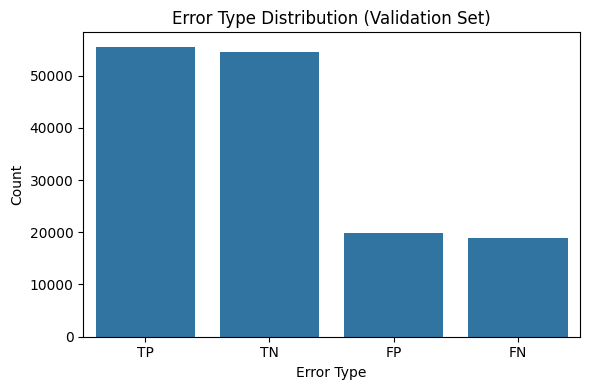

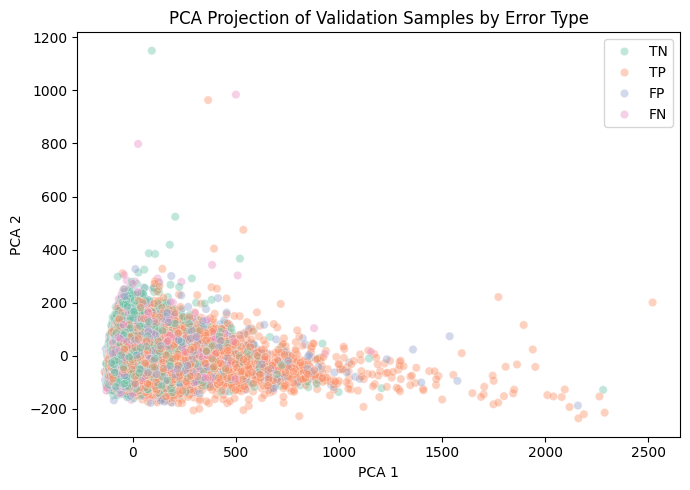


 Analyzing Error Samples (FN and FP)...

 Plotting Feature Distributions (FN)...


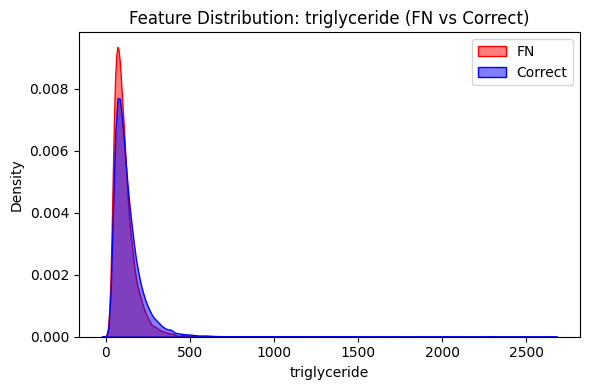

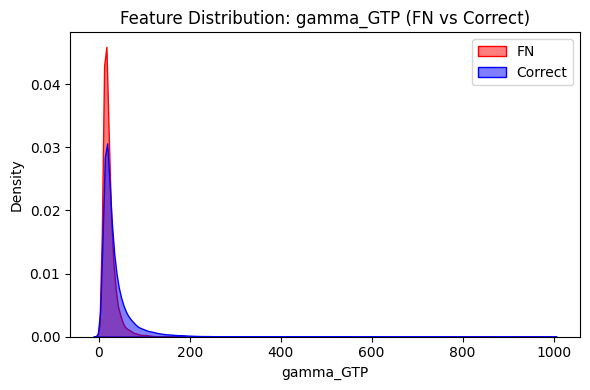

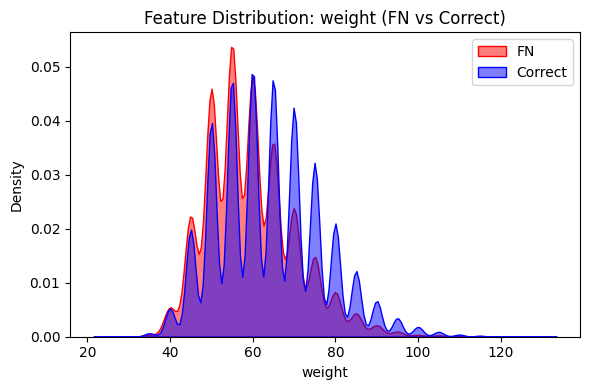


 Plotting Feature Distributions (FP)...


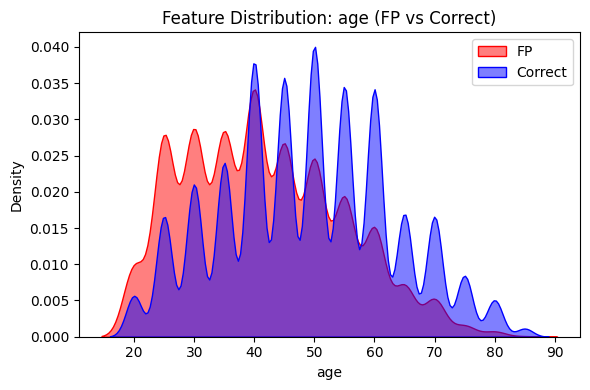

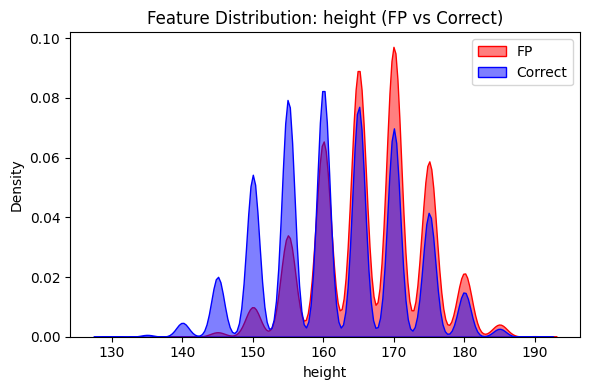

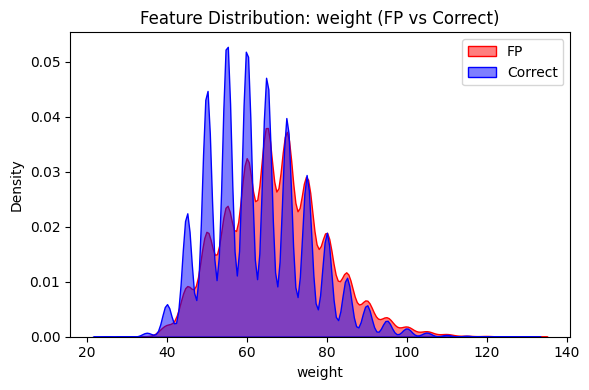


 SHAP Feature Importance and Distributions...


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


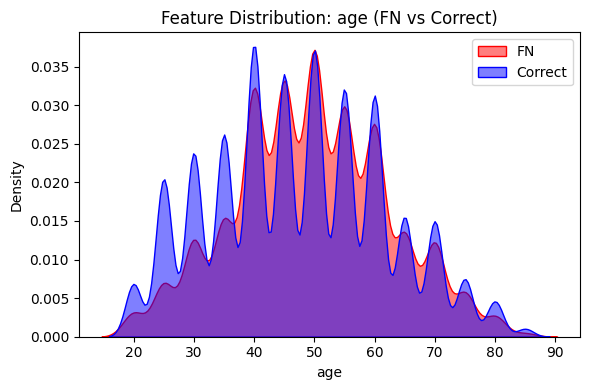

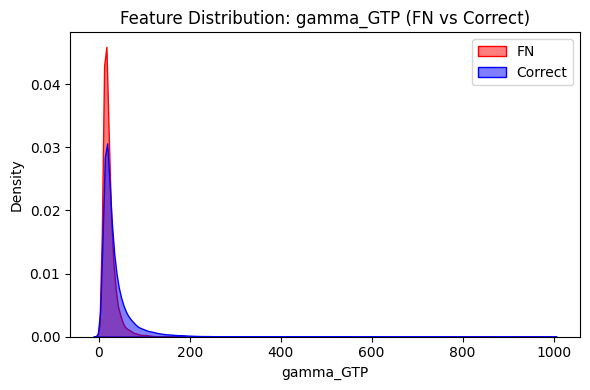

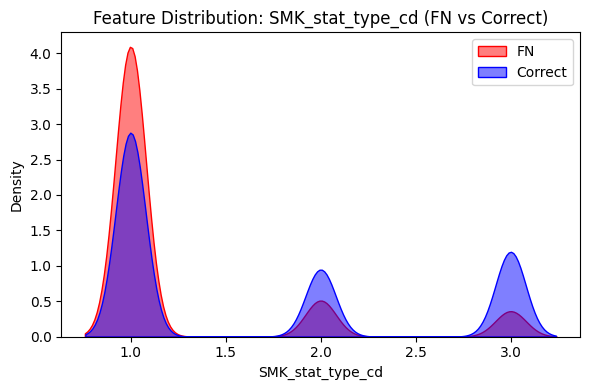

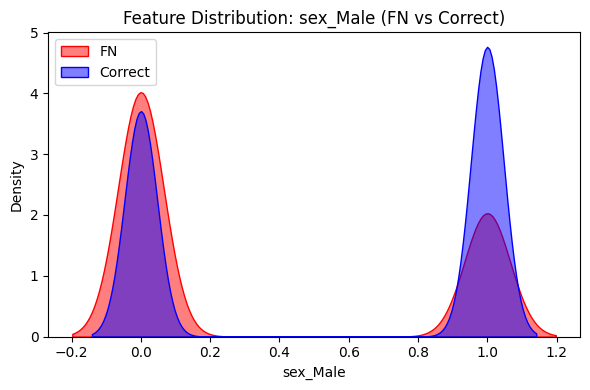

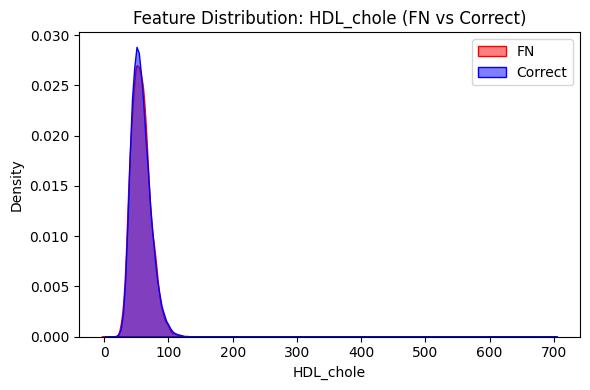

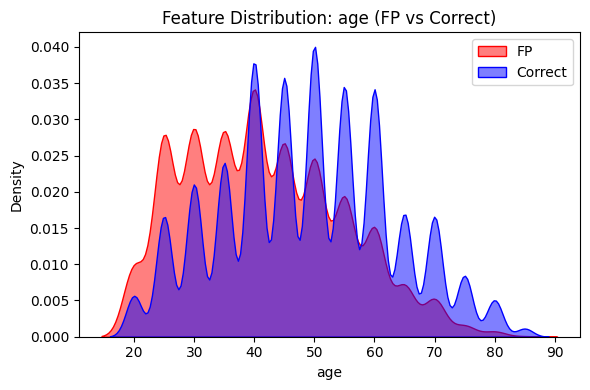

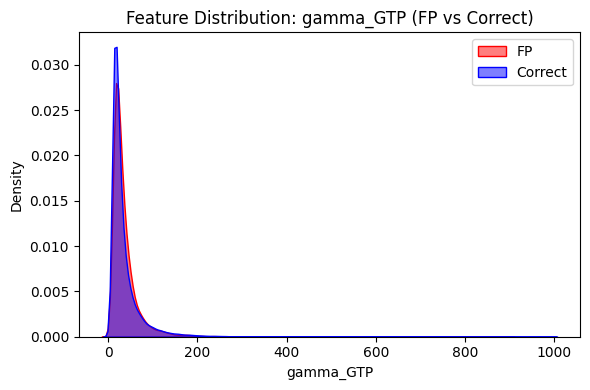

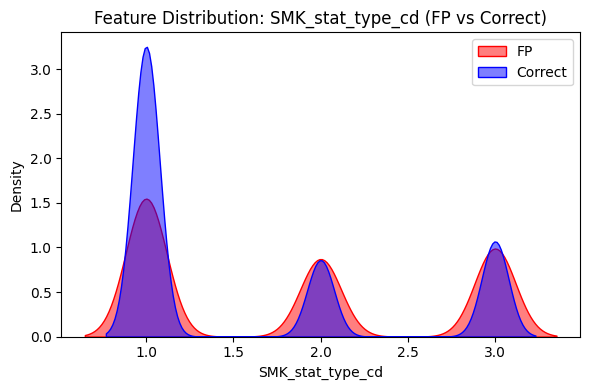

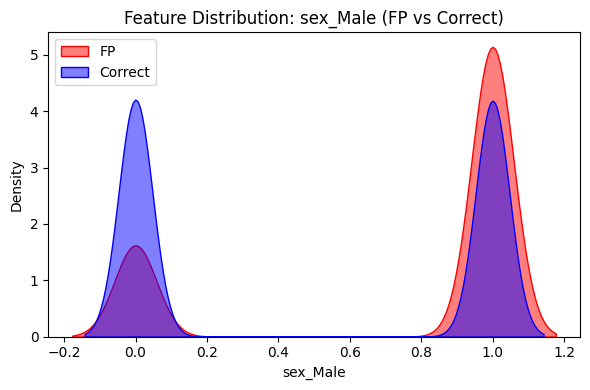

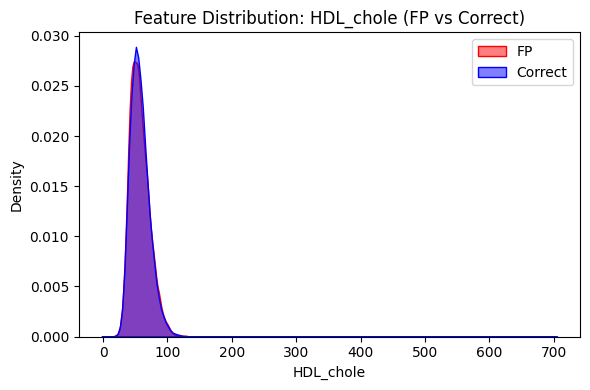


6. Analyzing Error Patterns (Pairplot)...


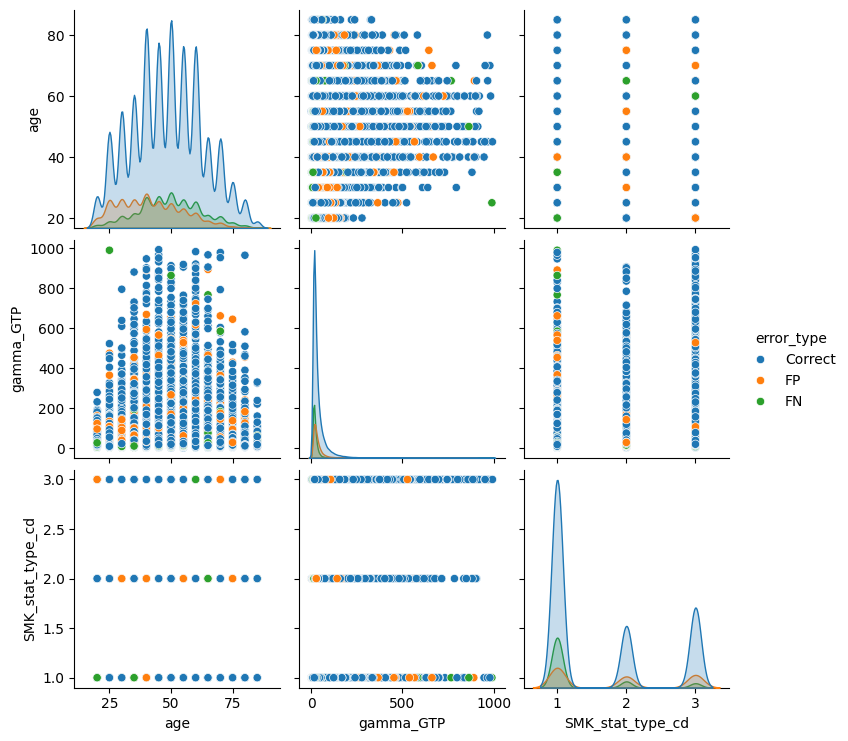


7. Generating Local Explanations (SHAP)...



FN Sample 30651:


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


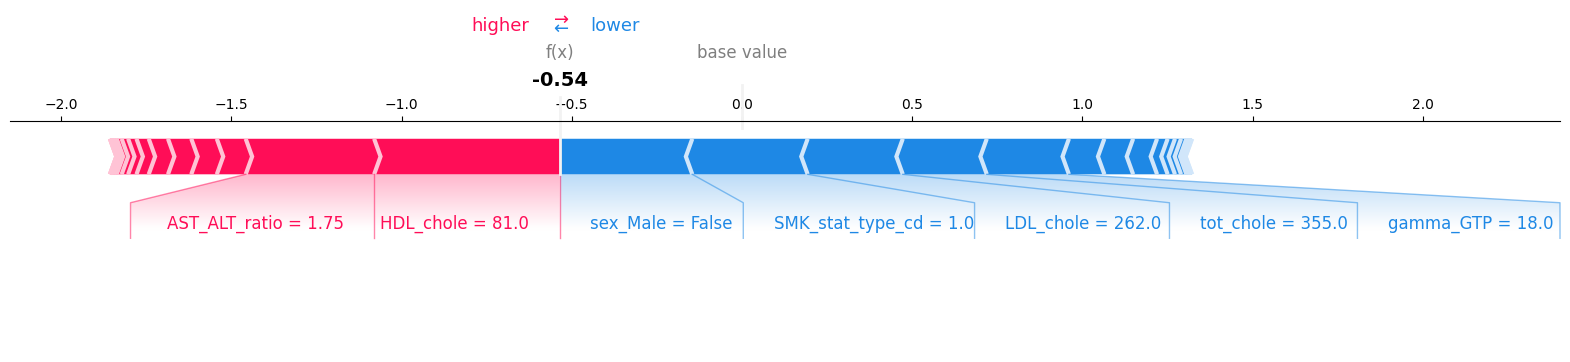


FN Sample 10227:


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


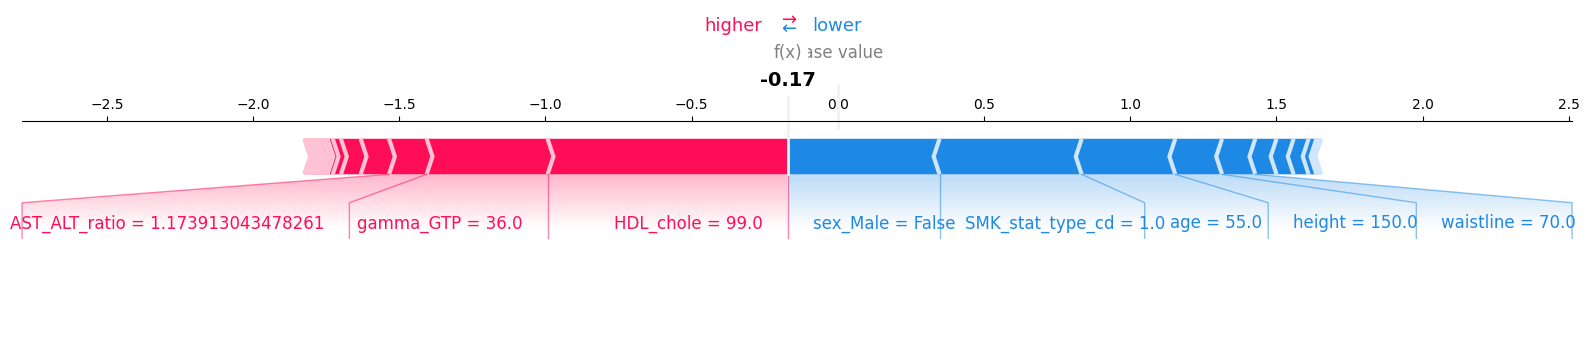


FN Sample 134425:


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


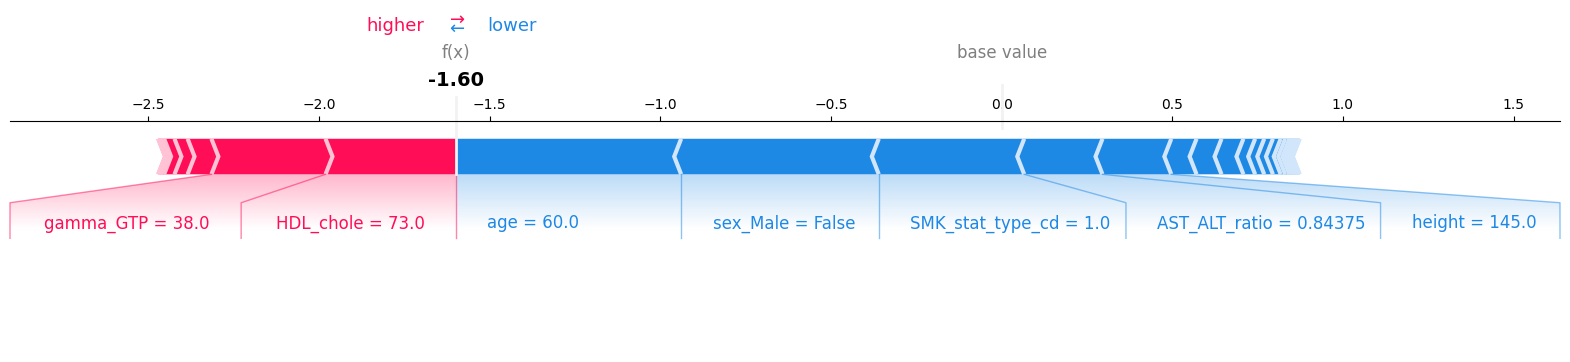


FP Sample 82157:


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


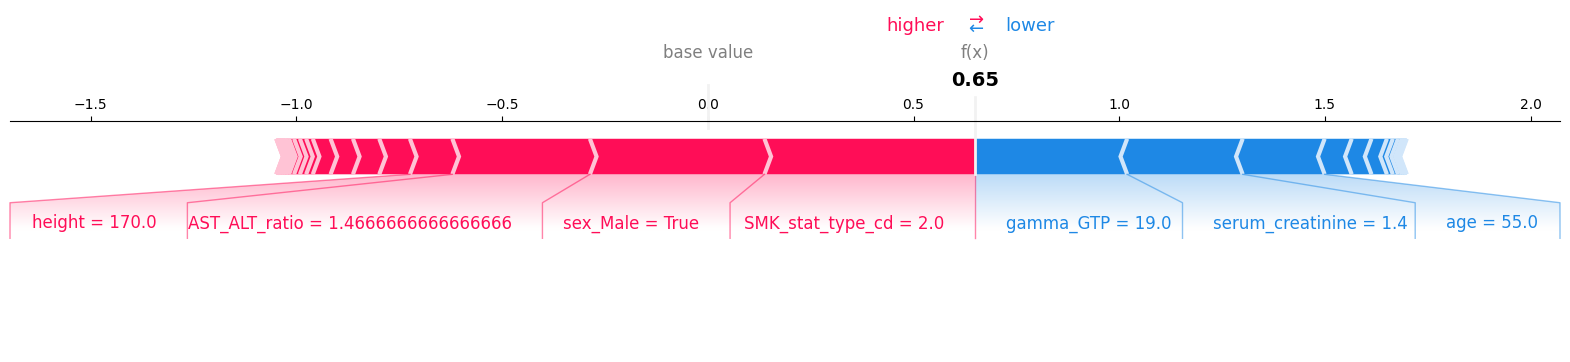


FP Sample 55020:


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


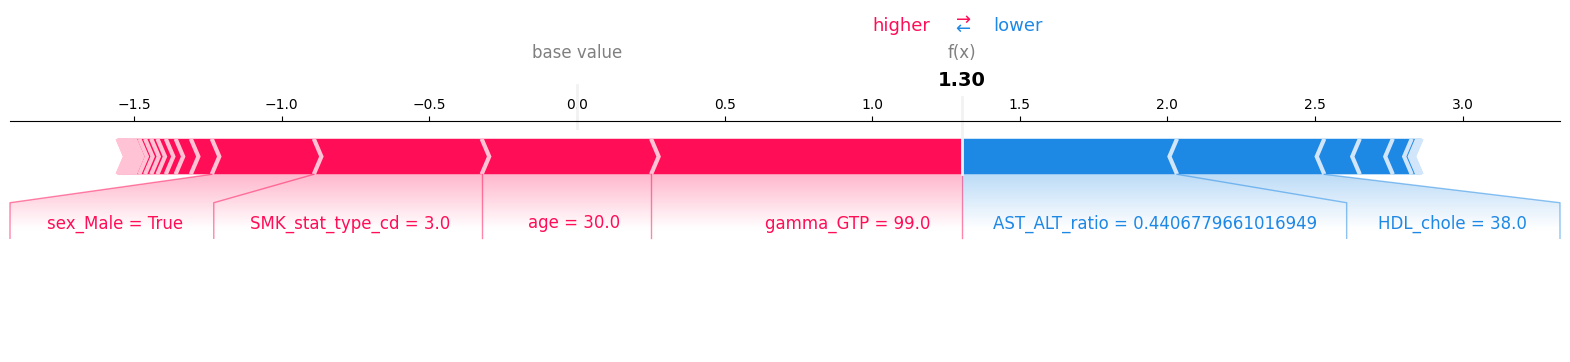


FP Sample 59896:


/opt/homebrew/anaconda3/envs/pytorch/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


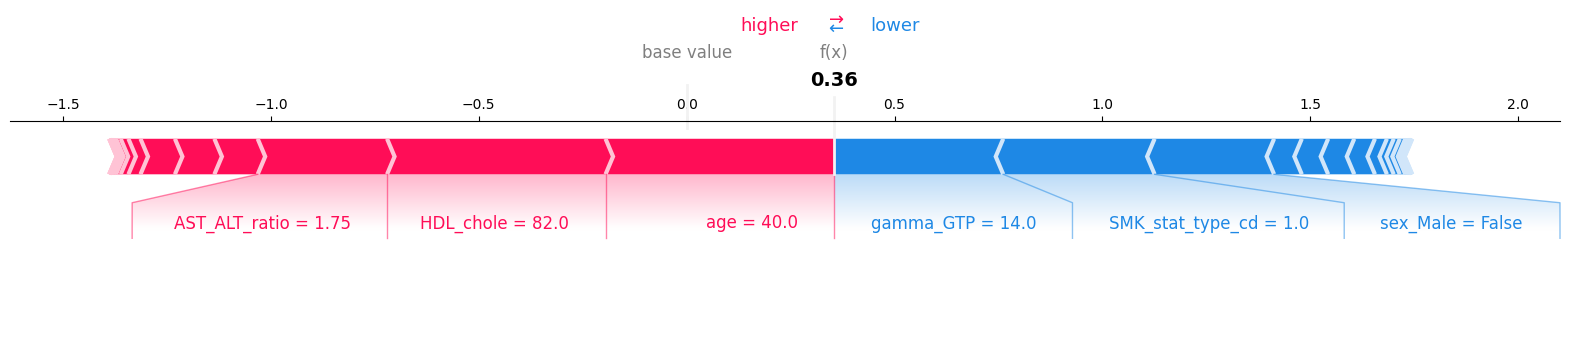

In [25]:
import sys

sys.path.append('../scripts')

from evaluate_models import run_error_analysis



results_lgb = run_error_analysis(X_val_lgb, y_val_lgb, y_val_pred, explainer=explainer)

### Error Analysis of the LightGBM Model

- **Error Type Distribution:**  
  The validation set shows a balanced number of true positives (TP) and true negatives (TN), with both false positives (FP) and false negatives (FN) occurring at lower but similar frequencies. This indicates the model does not have a strong bias toward either class, but misclassifications are still present.

- **PCA Visualization:**  
  The PCA projection of validation samples by error type reveals that TP, TN, FP, and FN samples are distributed throughout the feature space, with no clear separation. This suggests that errors are not confined to specific regions and may result from overlapping feature distributions.

- **Feature Distributions:**  
  Analysis of key features shows that FN and FP samples often overlap with correctly classified samples, but some patterns are observed:
    - FN samples tend to have lower values of `gamma_GTP` and `triglyceride`, and lower `sex_Male` and `SMK_stat_type_cd` values.
    - FP samples are more common among younger individuals, those with higher `height` and `weight`, and higher `sex_Male` and `SMK_stat_type_cd` values.
    - Differences in `age`, `HDL_chole`, and other clinical features are also observed between error types and correct predictions.

- **Pairplot and Local Explanations:**  
  Pairplot analysis confirms that errors are spread across the feature space, and SHAP force plots for individual FN and FP samples show that misclassifications are typically driven by a combination of demographic and clinical variables.

# 10. Save Model and Parameters

In [26]:
import os

# Create the models directory
os.makedirs('models', exist_ok=True)

import joblib
joblib.dump(final_model, '../models/final_lgb_model.pkl')

print("Model saved successfully!")

Model saved successfully!
